# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [16]:
Score=final['Score']

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
This is a very good bar. There are lots of nuts and different kinds of fruit, but there is a bit too much sweetener (honey, etc). Good for breakfast, or half of one as a snack to get me through to lunch/dinner.<br /><br />Great price! Cheaper than Kind bars, although not as many different kinds available.
Taylor's of Hargate Irish Breakfast tea is the only way to start you day.  The flavor is robust without being overdone and offers the little caffine kick I know I need to jump-start my morning.  Taylor's Tea also is lovely in the afternoon with a little sweet something.  Fine tea.
Great flavor and love the snap!  When your lookin

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
This is a very good bar. There are lots of nuts and different kinds of fruit, but there is a bit too much sweetener (honey, etc). Good for breakfast, or half of one as a snack to get me through to lunch/dinner.Great price! Cheaper than Kind bars, although not as many different kinds available.
Taylor's of Hargate Irish Breakfast tea is the only way to start you day.  The flavor is robust without being overdone and offers the little caffine kick I know I need to jump-start my morning.  Taylor's Tea also is lovely in the afternoon with a little sweet something.  Fine tea.
Great flavor and love the snap!  When your looking for something crunch

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Taylor is of Hargate Irish Breakfast tea is the only way to start you day.  The flavor is robust without being overdone and offers the little caffine kick I know I need to jump-start my morning.  Taylor is Tea also is lovely in the afternoon with a little sweet something.  Fine tea.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Taylor is of Hargate Irish Breakfast tea is the only way to start you day The flavor is robust without being overdone and offers the little caffine kick I know I need to jump start my morning Taylor is Tea also is lovely in the afternoon with a little sweet something Fine tea 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [01:07<00:00, 1309.76it/s]


In [26]:
preprocessed_reviews[1500]

'taylor hargate irish breakfast tea way start day flavor robust without overdone offers little caffine kick know need jump start morning taylor tea also lovely afternoon little sweet something fine tea'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 87773/87773 [01:06<00:00, 1315.49it/s]


# [4] Featurization

In [28]:
preprocessed_reviews=np.array(preprocessed_reviews)
preprocessed_summary=np.array(preprocessed_summary)
x_train=[]
x_test=[]
for i in range(int((preprocessed_reviews.shape[0]*0.7))+1):
    x_train.append(preprocessed_reviews[i]+" "+preprocessed_summary[i])
for i in range(int((preprocessed_reviews.shape[0]*0.7))+1,preprocessed_reviews.shape[0]):
    x_test.append(preprocessed_reviews[i]+" "+preprocessed_summary[i])
y_train=Score[:int((Score.shape[0]*0.7))+1]
y_test=Score[int((Score.shape[0]*0.7))+1:]
print(len(x_train))
print(len(x_test))
print(y_train.shape)
print(y_test.shape)

61442
26331
(61442,)
(26331,)


## [4.1] BAG OF WORDS

In [29]:
#BoW
count_vect = CountVectorizer(min_df= 0.01) #in scikit-learn
final_counts_train=count_vect.fit_transform(x_train)
final_counts_test=count_vect.transform(x_test)

## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(min_df= 0.01)
final_tfidf_train= tf_idf_vect.fit_transform(x_train)
final_tfidf_test=tf_idf_vect.transform(x_test)

## [4.4] Word2Vec

In [31]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())

100%|██████████| 61442/61442 [00:00<00:00, 94373.90it/s] 


In [32]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance[:int((preprocessed_reviews.shape[0]*0.7))+1],min_count=5,size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.784703254699707), ('fantastic', 0.7825158834457397), ('terrific', 0.7568631768226624), ('awesome', 0.749326229095459), ('good', 0.7091716527938843), ('wonderful', 0.7013852596282959), ('nice', 0.6126043796539307), ('fabulous', 0.5998133420944214), ('decent', 0.5994043946266174), ('amazing', 0.5928020477294922)]
[('greatest', 0.7014682292938232), ('nastiest', 0.6683268547058105), ('best', 0.660970151424408), ('tastiest', 0.6580258011817932), ('coolest', 0.6400653123855591), ('disgusting', 0.635493278503418), ('horrible', 0.6195787191390991), ('softest', 0.5737954378128052), ('closest', 0.5700803995132446), ('awful', 0.5627397894859314)]


In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15254
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'sure', 'death', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'great', 'received', 'shipment', 'could', 'hardly']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

###### Train

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 61442/61442 [02:28<00:00, 414.92it/s]

61442
100


###### Test

In [35]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 26331/26331 [01:05<00:00, 403.06it/s]

26331
100


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

###### Train

In [37]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 61442/61442 [34:41<00:00, 26.74it/s]  


###### Test

In [38]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 26331/26331 [15:13<00:00, 39.36it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [39]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [40]:
my_cv = TimeSeriesSplit(n_splits=10)
param_grid= {'n_estimators': [5,10,50,100,250,500]}
grid=GridSearchCV(RandomForestClassifier(max_depth=5), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)

In [41]:
%time grid.fit(final_counts_train,y_train)

CPU times: user 7.41 s, sys: 456 ms, total: 7.87 s
Wall time: 1min 11s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

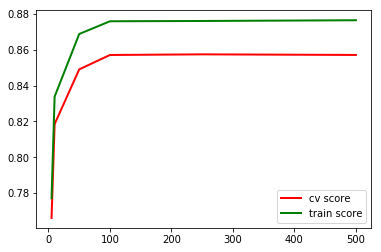

In [42]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["n_estimators"],cv_scores, param_grid["n_estimators"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.legend()
plt.show()

In [44]:
my_cv = TimeSeriesSplit(n_splits=10)
param_grid= {'max_depth': [20,22,24,26]}
grid=GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)

In [45]:
%time grid.fit(final_counts_train,y_train)

CPU times: user 40.5 s, sys: 112 ms, total: 40.6 s
Wall time: 3min 52s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [20, 22, 24, 26]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

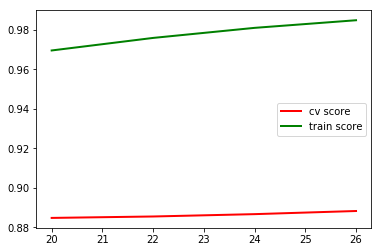

In [46]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["max_depth"],cv_scores, param_grid["max_depth"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.legend()
plt.show()

In [47]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
param_dist = {"n_estimators":sp_randint(90,120),
              "max_depth": sp_randint(24,30)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='roc_auc',random_state=25)

rf_random.fit(final_counts_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.90723574 0.90807042 0.9072536  0.9078436  0.9071161 ]
mean train scores [0.98412878 0.98602445 0.98408939 0.9859219  0.98417826]


In [48]:
rf_random.best_params_ 

{'max_depth': 29, 'n_estimators': 112}

Accuracy for max_depth: 29 ,n_estimators: 112
86.13041661919411
[[  978  3583]
 [   69 21701]]


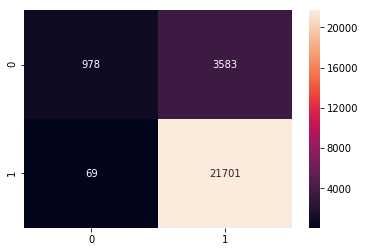

In [49]:
from sklearn.metrics import accuracy_score
optimal_param=rf_random.best_params_ 
pre=rf_random.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for max_depth:",optimal_param['max_depth'],',n_estimators:',optimal_param['n_estimators'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

Accuracy for max_depth: 29 ,n_estimators: 112
92.14543797402428
[[ 4808  4812]
 [   14 51808]]


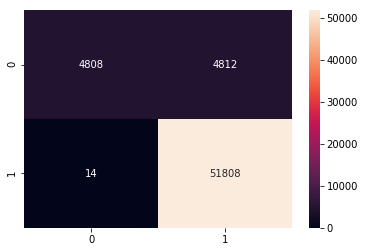

In [50]:
from sklearn.metrics import accuracy_score
optimal_param=rf_random.best_params_ 
pre=rf_random.predict(final_counts_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for max_depth:",optimal_param['max_depth'],',n_estimators:',optimal_param['n_estimators'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

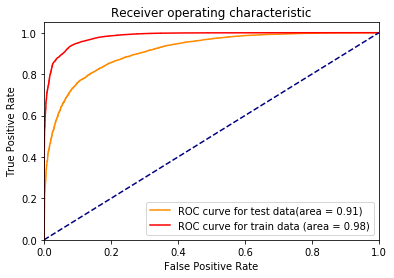

In [51]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(rf_random.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_counts_train,y_train)
train_calb_probs=caliberated.predict_proba(final_counts_train)
calb_probs=caliberated.predict_proba(final_counts_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [52]:
print(np.take(count_vect.get_feature_names(),np.argsort(-rf_random.best_estimator_.feature_importances_)[:20]))

['not' 'great' 'disappointed' 'bad' 'best' 'horrible' 'waste' 'love'
 'delicious' 'money' 'good' 'would' 'thought' 'excellent' 'perfect'
 'loves' 'away' 'taste' 'received' 'unfortunately']


### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [53]:
param_grid= {'n_estimators': [5,10,50,100,250,500]}
grid=GridSearchCV(RandomForestClassifier(max_depth=5), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 23.9 s, sys: 76 ms, total: 24 s
Wall time: 1min 52s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

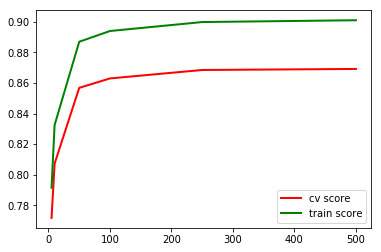

In [54]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["n_estimators"],cv_scores, param_grid["n_estimators"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.legend()
plt.show()

In [55]:
#e=grid.best_params_['n_estimators']
param_grid= {"max_depth":[5,10,15,25,30,35,40]}
grid=GridSearchCV(RandomForestClassifier(n_estimators=120), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)

In [56]:
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 1min 27s, sys: 132 ms, total: 1min 28s
Wall time: 9min 10s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 25, 30, 35, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

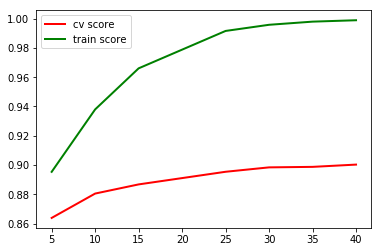

In [57]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["max_depth"],cv_scores, param_grid["max_depth"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.legend()
plt.show()

In [58]:
param_dist = {"n_estimators":sp_randint(80,115),
              "max_depth": sp_randint(25,40)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=7,cv=10,scoring='roc_auc',random_state=25)

%time rf_random.fit(final_tfidf_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

CPU times: user 4min 36s, sys: 6.62 s, total: 4min 43s
Wall time: 20min 42s
mean test scores [0.91380247 0.91657753 0.91518992 0.91485064 0.91612434 0.91316236
 0.91099549]
mean train scores [0.99152541 0.99743455 0.99699298 0.99699364 0.99578166 0.99135412
 0.98713421]


Accuracy for max_depth: 38 ,n_estimators: 103
87.47863734761307
[[ 1387  3174]
 [  123 21647]]


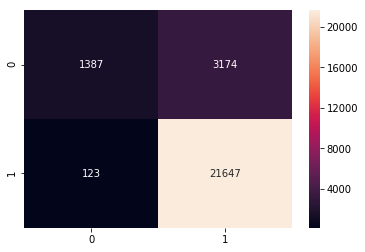

In [59]:
from sklearn.metrics import accuracy_score
optimal_param=rf_random.best_params_ 
pre=rf_random.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for max_depth:",optimal_param['max_depth'],',n_estimators:',optimal_param['n_estimators'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

Accuracy for max_depth: 38 ,n_estimators: 103
94.95133621952411
[[ 6527  3093]
 [    9 51813]]


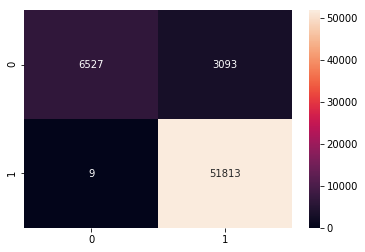

In [60]:
from sklearn.metrics import accuracy_score
optimal_param=rf_random.best_params_ 
pre=rf_random.predict(final_tfidf_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for max_depth:",optimal_param['max_depth'],',n_estimators:',optimal_param['n_estimators'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

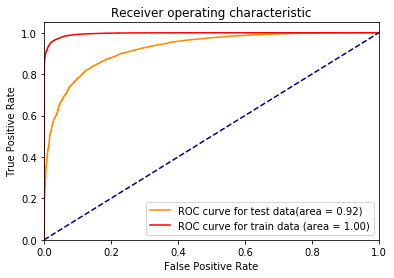

In [61]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(rf_random.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train,y_train)
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [62]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
print(np.take(tf_idf_vect.get_feature_names(),np.argsort(-rf_random.best_estimator_.feature_importances_)[:20]))

['not' 'great' 'disappointed' 'bad' 'horrible' 'best' 'good' 'money'
 'love' 'waste' 'delicious' 'would' 'taste' 'thought' 'away' 'received'
 'product' 'like' 'perfect' 'excellent']


### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [63]:
param_grid= {'n_estimators': [5,10,50,100,250,500]}
grid=GridSearchCV(RandomForestClassifier(), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)
%time grid.fit(sent_vectors_train,y_train)

CPU times: user 9min 55s, sys: 4.81 s, total: 10min
Wall time: 30min 50s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

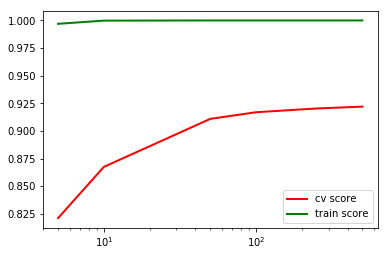

In [64]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["n_estimators"],cv_scores, param_grid["n_estimators"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

In [65]:
param_grid= {"max_depth":[5,10,15,25,30,35,40]}
grid=GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)

In [66]:
%time grid.fit(sent_vectors_train,y_train)

CPU times: user 4min 41s, sys: 4.48 s, total: 4min 45s
Wall time: 15min 55s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 25, 30, 35, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

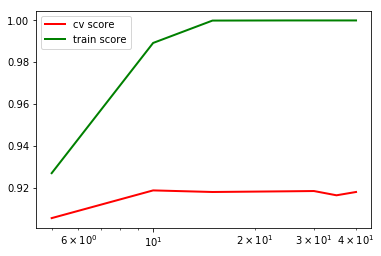

In [67]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["max_depth"],cv_scores, param_grid["max_depth"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

In [68]:
param_dist = {"n_estimators":sp_randint(90,115),
              "max_depth": sp_randint(10,25)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=7,cv=10,scoring='roc_auc',random_state=25)

%time rf_random.fit(sent_vectors_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

CPU times: user 4min 7s, sys: 7.27 s, total: 4min 15s
Wall time: 29min 35s
mean test scores [0.92570217 0.92536255 0.9249318  0.9264489  0.92418721 0.92476973
 0.92428245]
mean train scores [0.99934561 1.         0.99999034 0.99489705 1.         0.99999984
 0.99979355]


Accuracy for depth: 12 ,n_estimators: 98
88.65975466180548
[[ 1885  2676]
 [  310 21460]]


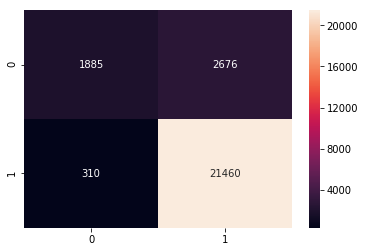

In [69]:
from sklearn.metrics import accuracy_score
optimal_param=rf_random.best_params_ 
pre=rf_random.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',n_estimators:',optimal_param['n_estimators'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

Accuracy for depth: 12 ,n_estimators: 98
95.58770873343967
[[ 7024  2596]
 [  115 51707]]


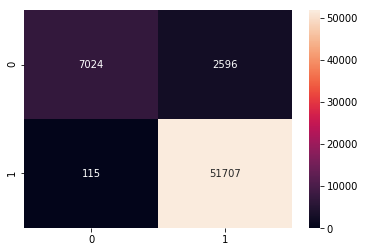

In [70]:
from sklearn.metrics import accuracy_score
optimal_param=rf_random.best_params_ 
pre=rf_random.predict(sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',n_estimators:',optimal_param['n_estimators'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

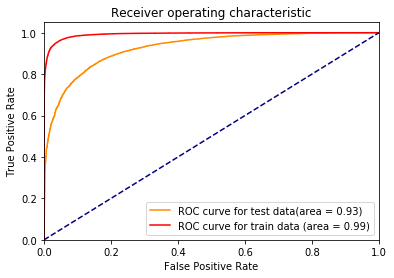

In [71]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(rf_random.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [72]:
# Please write all the code with proper documentation
param_grid= {'n_estimators': [5,10,50,100,250,500]}
grid=GridSearchCV(RandomForestClassifier(max_depth=5), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 5min 53s, sys: 3.64 s, total: 5min 57s
Wall time: 13min 59s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

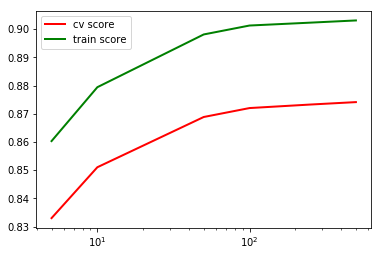

In [73]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["n_estimators"],cv_scores, param_grid["n_estimators"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

In [74]:
param_grid= {"max_depth":[5,10,15,25,30,35,40]}
grid=GridSearchCV(RandomForestClassifier(n_estimators=120), param_grid, cv=my_cv, scoring="roc_auc",n_jobs=-1)

In [75]:
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 4min 51s, sys: 4.29 s, total: 4min 55s
Wall time: 19min 12s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 25, 30, 35, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

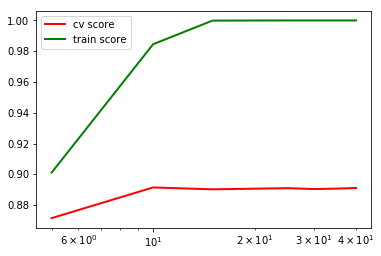

In [76]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["max_depth"],cv_scores, param_grid["max_depth"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.xscale("log")
plt.legend()
plt.show()

In [77]:
param_dist = {"n_estimators":sp_randint(100,140),
              "max_depth": sp_randint(8,20)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=7,cv=10,scoring='roc_auc',random_state=25)

%time rf_random.fit(tfidf_sent_vectors_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

CPU times: user 4min 31s, sys: 8.19 s, total: 4min 40s
Wall time: 29min 31s
mean test scores [0.90165036 0.90135994 0.89915583 0.90160372 0.90087551 0.89740938
 0.90080197]
mean train scores [0.99255375 0.99895008 0.97124662 0.99255395 0.99238508 0.95503474
 0.98441393]


Accuracy for depth: 12 ,n_estimators: 126
87.26216247009229
[[ 1480  3081]
 [  273 21497]]


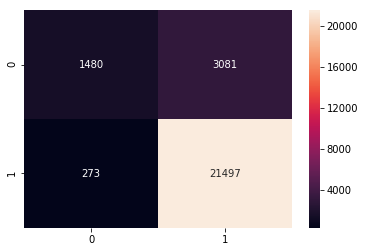

In [78]:
from sklearn.metrics import accuracy_score
optimal_param=rf_random.best_params_ 
pre=rf_random.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',n_estimators:',optimal_param['n_estimators'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

Accuracy for depth: 12 ,n_estimators: 126
94.0415351062791
[[ 6075  3545]
 [  116 51706]]


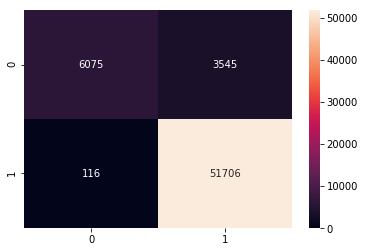

In [79]:
from sklearn.metrics import accuracy_score
optimal_param=rf_random.best_params_ 
pre=rf_random.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for depth:",optimal_param['max_depth'],',n_estimators:',optimal_param['n_estimators'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

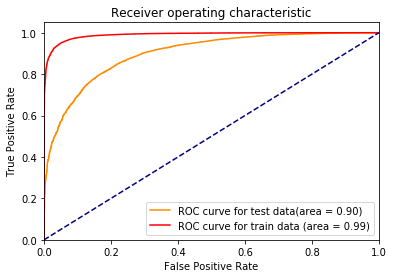

In [80]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(rf_random.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [82]:
from xgboost import XGBClassifier
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
eval_set = [(final_counts_train, y_train), (final_counts_test, y_test)]
eval_metric = ["auc"]
%time model.fit(final_counts_train, y_train, eval_metric=eval_metric, eval_set=eval_set,early_stopping_rounds=10, verbose=True)


[0]	validation_0-auc:0.71659	validation_1-auc:0.733196
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.746886	validation_1-auc:0.759752
[2]	validation_0-auc:0.805721	validation_1-auc:0.814524
[3]	validation_0-auc:0.812634	validation_1-auc:0.821069
[4]	validation_0-auc:0.81487	validation_1-auc:0.823486
[5]	validation_0-auc:0.816305	validation_1-auc:0.824286
[6]	validation_0-auc:0.815191	validation_1-auc:0.82133
[7]	validation_0-auc:0.812901	validation_1-auc:0.819268
[8]	validation_0-auc:0.820527	validation_1-auc:0.827061
[9]	validation_0-auc:0.824069	validation_1-auc:0.831021
[10]	validation_0-auc:0.82504	validation_1-auc:0.830789
[11]	validation_0-auc:0.823286	validation_1-auc:0.828878
[12]	validation_0-auc:0.820826	validation_1-auc:0.826266
[13]	validation_0-auc:0.826925	validation_1-auc:0.832333
[14]	validation_0-auc:0.827928	validation_1-auc:0.832453
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

In [89]:
from xgboost import XGBClassifier
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)
eval_set = [(final_counts_train, y_train), (final_counts_test, y_test)]
eval_metric = ["auc"]
%time model.fit(final_counts_train, y_train, eval_metric=eval_metric, eval_set=eval_set,early_stopping_rounds=10, verbose=True)


[0]	validation_0-auc:0.728787	validation_1-auc:0.743807
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.760565	validation_1-auc:0.768325
[2]	validation_0-auc:0.817292	validation_1-auc:0.823744
[3]	validation_0-auc:0.824556	validation_1-auc:0.829255
[4]	validation_0-auc:0.832324	validation_1-auc:0.83751
[5]	validation_0-auc:0.834409	validation_1-auc:0.838847
[6]	validation_0-auc:0.833071	validation_1-auc:0.833448
[7]	validation_0-auc:0.830901	validation_1-auc:0.832658
[8]	validation_0-auc:0.836009	validation_1-auc:0.837282
[9]	validation_0-auc:0.837854	validation_1-auc:0.840237
[10]	validation_0-auc:0.835346	validation_1-auc:0.837189
[11]	validation_0-auc:0.837848	validation_1-auc:0.839575
[12]	validation_0-auc:0.836379	validation_1-auc:0.838109
[13]	validation_0-auc:0.843583	validation_1-auc:0.845393
[14]	validation_0-auc:0.843394	validation_1-auc:0.844319

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

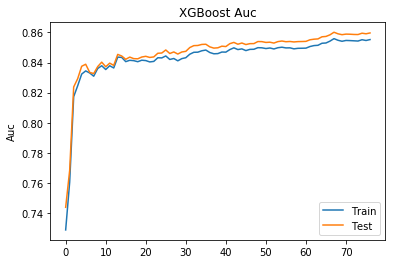

In [90]:
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Auc')
plt.title('XGBoost Auc')
plt.show()


In [91]:
param_grid= {'max_depth': [5,6,7,8,9,10,11,12,13,14,15,16,17]}
from sklearn.model_selection import GridSearchCV
grid=GridSearchCV(XGBClassifier(n_estimators=67), param_grid, scoring="f1",n_jobs=-1)
%time grid.fit(final_counts_train,y_train)


CPU times: user 31.3 s, sys: 604 ms, total: 31.9 s
Wall time: 3min 56s


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=67,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

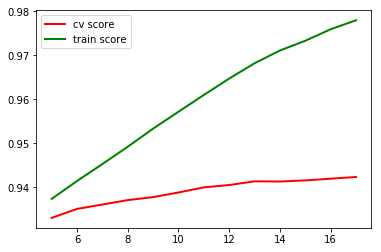

In [92]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["max_depth"],cv_scores, param_grid["max_depth"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.legend()
plt.show()

In [93]:
from sklearn.model_selection import RandomizedSearchCV
params = {
        'gamma': [0, 1, 5],
        'learning_rate': [0.01,0.05,0.1],
        'subsample':[0.8,0.9,1]
        }
random_search = RandomizedSearchCV(XGBClassifier(n_estimators=67,max_depth=14), param_distributions=params, n_iter=10, scoring='f1')
%time random_search.fit(final_counts_train,y_train)

CPU times: user 10min 10s, sys: 2.51 s, total: 10min 13s
Wall time: 10min 13s


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=14, min_child_weight=1, missing=None, n_estimators=67,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.8, 0.9, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [94]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=14, min_child_weight=1, missing=None, n_estimators=67,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)


Accuracy for learning rate: 0.1 ,n_estimators: 0
89.52945197675743
[[ 2380  2181]
 [  576 21194]]


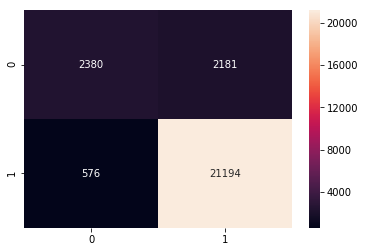

In [95]:
from sklearn.metrics import accuracy_score
optimal_param=random_search.best_params_ 
pre=random_search.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for learning rate:",optimal_param['learning_rate'],',n_estimators:',optimal_param['gamma'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

Accuracy for learning rate: 0.1 ,n_estimators: 0
94.18150450831678
[[ 6797  2823]
 [  752 51070]]


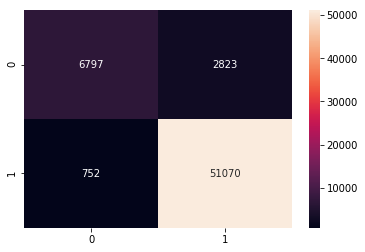

In [96]:
from sklearn.metrics import accuracy_score
optimal_param=random_search.best_params_ 
pre=random_search.predict(final_counts_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for learning rate:",optimal_param['learning_rate'],',n_estimators:',optimal_param['gamma'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

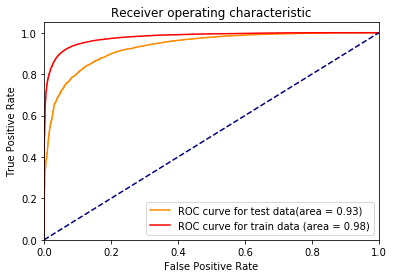

In [97]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(random_search.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_counts_train,y_train)
train_calb_probs=caliberated.predict_proba(final_counts_train)
calb_probs=caliberated.predict_proba(final_counts_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [4]:
print(np.take(count_vect.get_feature_names(),np.argsort(-rf_random.best_estimator_.feature_importances_)[:20]))

['not' 'great' 'disappointed' 'bad' 'horrible' 'best' 'good' 'money''love' 'waste' 'delicious' 'would' 'taste' 'thought' 'away' 'received''product' 'like' 'perfect' 'excellent']


### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [98]:
from xgboost import XGBClassifier
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)
eval_set = [(final_tfidf_train, y_train), (final_tfidf_test, y_test)]
eval_metric = ["auc"]
%time model.fit(final_tfidf_train, y_train, eval_metric=eval_metric, eval_set=eval_set,early_stopping_rounds=10, verbose=True)


[0]	validation_0-auc:0.73564	validation_1-auc:0.749244
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.765164	validation_1-auc:0.769369
[2]	validation_0-auc:0.825292	validation_1-auc:0.83055
[3]	validation_0-auc:0.831872	validation_1-auc:0.834713
[4]	validation_0-auc:0.834431	validation_1-auc:0.838456
[5]	validation_0-auc:0.836522	validation_1-auc:0.840144
[6]	validation_0-auc:0.835254	validation_1-auc:0.83559
[7]	validation_0-auc:0.835652	validation_1-auc:0.837664
[8]	validation_0-auc:0.839988	validation_1-auc:0.842157
[9]	validation_0-auc:0.841601	validation_1-auc:0.844802
[10]	validation_0-auc:0.84042	validation_1-auc:0.842562
[11]	validation_0-auc:0.843837	validation_1-auc:0.845878
[12]	validation_0-auc:0.842371	validation_1-auc:0.844185
[13]	validation_0-auc:0.850215	validation_1-auc:0.851676
[14]	validation_0-auc:0.850759	validation_1-auc:0.851299
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

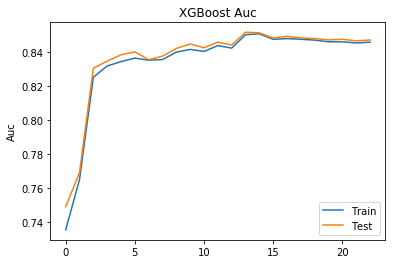

In [99]:
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Auc')
plt.title('XGBoost Auc')
plt.show()


In [100]:
param_grid= {'max_depth': [5,6,7,8,9,10,11,12,13,14,15,16,17]}
from sklearn.model_selection import GridSearchCV
grid=GridSearchCV(XGBClassifier(n_estimators=13), param_grid, scoring="f1",n_jobs=-1)
%time grid.fit(final_tfidf_train,y_train)


CPU times: user 13.2 s, sys: 532 ms, total: 13.7 s
Wall time: 2min 7s


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

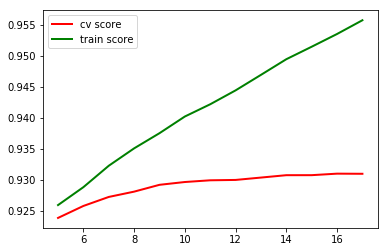

In [101]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["max_depth"],cv_scores, param_grid["max_depth"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.legend()
plt.show()

In [102]:
from sklearn.model_selection import RandomizedSearchCV
params = {
        'gamma': [0, 1, 5],
        'learning_rate': [0.01,0.05,0.1],
        'subsample':[0.8,0.9,1]
        }
random_search = RandomizedSearchCV(XGBClassifier(n_estimators=13,max_depth=10), param_distributions=params, n_iter=10, scoring='f1')
%time random_search.fit(final_tfidf_train,y_train)

CPU times: user 3min 2s, sys: 264 ms, total: 3min 3s
Wall time: 3min 3s


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.8, 0.9, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

Accuracy for learning rate: 0.1 ,n_estimators: 5
87.05328320230906
[[ 1670  2891]
 [  518 21252]]


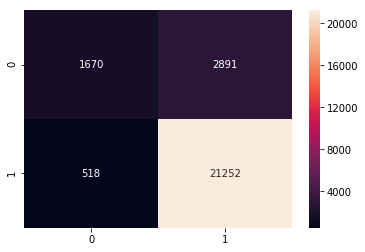

In [103]:
from sklearn.metrics import accuracy_score
optimal_param=random_search.best_params_ 
pre=random_search.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for learning rate:",optimal_param['learning_rate'],',n_estimators:',optimal_param['gamma'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

Accuracy for learning rate: 0.1 ,n_estimators: 5
88.74385599427102
[[ 3603  6017]
 [  899 50923]]


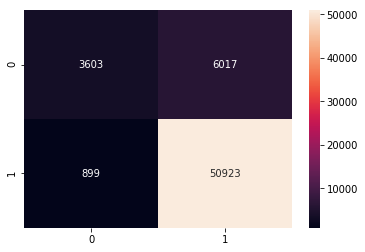

In [104]:
from sklearn.metrics import accuracy_score
optimal_param=random_search.best_params_ 
pre=random_search.predict(final_tfidf_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for learning rate:",optimal_param['learning_rate'],',n_estimators:',optimal_param['gamma'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

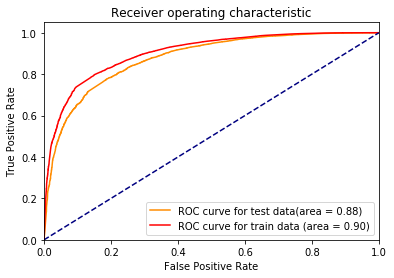

In [105]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(random_search.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train,y_train)
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [5]:
print(np.take(tf_idf_vect.get_feature_names(),np.argsort(-rf_random.best_estimator_.feature_importances_)[:20]))

['not' 'great' 'disappointed' 'bad' 'horrible' 'best' 'good' 'money''love' 'waste' 'delicious' 'would' 'taste' 'thought' 'away' 'received' 'product' 'like' 'perfect' 'excellent']


### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [106]:
from xgboost import XGBClassifier
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)
eval_set = [(np.array(sent_vectors_train), y_train), (np.array(sent_vectors_test), y_test)]
eval_metric = ["auc"]
%time model.fit(np.array(sent_vectors_train), y_train, eval_metric=eval_metric, eval_set=eval_set,early_stopping_rounds=10, verbose=True)


[0]	validation_0-auc:0.820291	validation_1-auc:0.80424
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.860111	validation_1-auc:0.84406
[2]	validation_0-auc:0.887923	validation_1-auc:0.872557
[3]	validation_0-auc:0.894834	validation_1-auc:0.880576
[4]	validation_0-auc:0.897947	validation_1-auc:0.881831
[5]	validation_0-auc:0.905811	validation_1-auc:0.890087
[6]	validation_0-auc:0.907589	validation_1-auc:0.892202
[7]	validation_0-auc:0.909098	validation_1-auc:0.894026
[8]	validation_0-auc:0.911817	validation_1-auc:0.89649
[9]	validation_0-auc:0.911395	validation_1-auc:0.895684
[10]	validation_0-auc:0.911047	validation_1-auc:0.895425
[11]	validation_0-auc:0.913134	validation_1-auc:0.897473
[12]	validation_0-auc:0.91448	validation_1-auc:0.899184
[13]	validation_0-auc:0.914071	validation_1-auc:0.898908
[14]	validation_0-auc:0.915039	validation_1-auc:0.899425
[1

[141]	validation_0-auc:0.929467	validation_1-auc:0.915111
[142]	validation_0-auc:0.92957	validation_1-auc:0.915167
[143]	validation_0-auc:0.929552	validation_1-auc:0.915175
[144]	validation_0-auc:0.929655	validation_1-auc:0.915266
[145]	validation_0-auc:0.929716	validation_1-auc:0.915332
[146]	validation_0-auc:0.929868	validation_1-auc:0.915471
[147]	validation_0-auc:0.929936	validation_1-auc:0.915555
[148]	validation_0-auc:0.930025	validation_1-auc:0.915664
[149]	validation_0-auc:0.930127	validation_1-auc:0.915764
[150]	validation_0-auc:0.930122	validation_1-auc:0.915775
[151]	validation_0-auc:0.930148	validation_1-auc:0.915809
[152]	validation_0-auc:0.930256	validation_1-auc:0.915858
[153]	validation_0-auc:0.930419	validation_1-auc:0.916013
[154]	validation_0-auc:0.930484	validation_1-auc:0.916063
[155]	validation_0-auc:0.93049	validation_1-auc:0.916029
[156]	validation_0-auc:0.930611	validation_1-auc:0.91612
[157]	validation_0-auc:0.930716	validation_1-auc:0.916217
[158]	validation_

[283]	validation_0-auc:0.937526	validation_1-auc:0.922041
[284]	validation_0-auc:0.937569	validation_1-auc:0.922081
[285]	validation_0-auc:0.937674	validation_1-auc:0.922164
[286]	validation_0-auc:0.937715	validation_1-auc:0.922216
[287]	validation_0-auc:0.937764	validation_1-auc:0.922252
[288]	validation_0-auc:0.937841	validation_1-auc:0.922321
[289]	validation_0-auc:0.937895	validation_1-auc:0.922349
[290]	validation_0-auc:0.937934	validation_1-auc:0.922388
[291]	validation_0-auc:0.93799	validation_1-auc:0.922435
[292]	validation_0-auc:0.938031	validation_1-auc:0.922466
[293]	validation_0-auc:0.938122	validation_1-auc:0.922522
[294]	validation_0-auc:0.938188	validation_1-auc:0.922536
[295]	validation_0-auc:0.938254	validation_1-auc:0.922583
[296]	validation_0-auc:0.938285	validation_1-auc:0.922615
[297]	validation_0-auc:0.938321	validation_1-auc:0.922622
[298]	validation_0-auc:0.938361	validation_1-auc:0.922656
[299]	validation_0-auc:0.938436	validation_1-auc:0.922726
[300]	validatio

[425]	validation_0-auc:0.944268	validation_1-auc:0.927717
[426]	validation_0-auc:0.944287	validation_1-auc:0.927723
[427]	validation_0-auc:0.94431	validation_1-auc:0.927759
[428]	validation_0-auc:0.94436	validation_1-auc:0.927803
[429]	validation_0-auc:0.944416	validation_1-auc:0.927845
[430]	validation_0-auc:0.944481	validation_1-auc:0.927918
[431]	validation_0-auc:0.944525	validation_1-auc:0.927953
[432]	validation_0-auc:0.944559	validation_1-auc:0.927988
[433]	validation_0-auc:0.944609	validation_1-auc:0.92801
[434]	validation_0-auc:0.944654	validation_1-auc:0.928051
[435]	validation_0-auc:0.944689	validation_1-auc:0.928072
[436]	validation_0-auc:0.94472	validation_1-auc:0.928091
[437]	validation_0-auc:0.944748	validation_1-auc:0.928103
[438]	validation_0-auc:0.944813	validation_1-auc:0.928171
[439]	validation_0-auc:0.944843	validation_1-auc:0.928189
[440]	validation_0-auc:0.944898	validation_1-auc:0.928241
[441]	validation_0-auc:0.944919	validation_1-auc:0.928269
[442]	validation_0

[567]	validation_0-auc:0.949446	validation_1-auc:0.932046
[568]	validation_0-auc:0.949474	validation_1-auc:0.932065
[569]	validation_0-auc:0.949503	validation_1-auc:0.93209
[570]	validation_0-auc:0.949523	validation_1-auc:0.932113
[571]	validation_0-auc:0.949552	validation_1-auc:0.93214
[572]	validation_0-auc:0.949566	validation_1-auc:0.93215
[573]	validation_0-auc:0.949592	validation_1-auc:0.932177
[574]	validation_0-auc:0.949634	validation_1-auc:0.932204
[575]	validation_0-auc:0.949676	validation_1-auc:0.932238
[576]	validation_0-auc:0.949709	validation_1-auc:0.932255
[577]	validation_0-auc:0.949744	validation_1-auc:0.932291
[578]	validation_0-auc:0.949778	validation_1-auc:0.932325
[579]	validation_0-auc:0.949806	validation_1-auc:0.932366
[580]	validation_0-auc:0.949829	validation_1-auc:0.932389
[581]	validation_0-auc:0.949872	validation_1-auc:0.932421
[582]	validation_0-auc:0.949905	validation_1-auc:0.932436
[583]	validation_0-auc:0.949918	validation_1-auc:0.932452
[584]	validation_

[709]	validation_0-auc:0.953477	validation_1-auc:0.935325
[710]	validation_0-auc:0.953497	validation_1-auc:0.935339
[711]	validation_0-auc:0.953529	validation_1-auc:0.935365
[712]	validation_0-auc:0.953554	validation_1-auc:0.935382
[713]	validation_0-auc:0.953576	validation_1-auc:0.935394
[714]	validation_0-auc:0.953598	validation_1-auc:0.93542
[715]	validation_0-auc:0.953631	validation_1-auc:0.935444
[716]	validation_0-auc:0.953658	validation_1-auc:0.935453
[717]	validation_0-auc:0.953678	validation_1-auc:0.93546
[718]	validation_0-auc:0.953707	validation_1-auc:0.935481
[719]	validation_0-auc:0.953727	validation_1-auc:0.935498
[720]	validation_0-auc:0.95376	validation_1-auc:0.935516
[721]	validation_0-auc:0.953782	validation_1-auc:0.935538
[722]	validation_0-auc:0.953798	validation_1-auc:0.935557
[723]	validation_0-auc:0.953821	validation_1-auc:0.935569
[724]	validation_0-auc:0.953845	validation_1-auc:0.935582
[725]	validation_0-auc:0.953871	validation_1-auc:0.935598
[726]	validation_

[851]	validation_0-auc:0.956587	validation_1-auc:0.937577
[852]	validation_0-auc:0.956604	validation_1-auc:0.937592
[853]	validation_0-auc:0.956607	validation_1-auc:0.937594
[854]	validation_0-auc:0.95662	validation_1-auc:0.937607
[855]	validation_0-auc:0.956637	validation_1-auc:0.93762
[856]	validation_0-auc:0.956662	validation_1-auc:0.937638
[857]	validation_0-auc:0.95668	validation_1-auc:0.937645
[858]	validation_0-auc:0.956697	validation_1-auc:0.937649
[859]	validation_0-auc:0.95672	validation_1-auc:0.937664
[860]	validation_0-auc:0.956745	validation_1-auc:0.937669
[861]	validation_0-auc:0.95677	validation_1-auc:0.937687
[862]	validation_0-auc:0.956797	validation_1-auc:0.937699
[863]	validation_0-auc:0.956814	validation_1-auc:0.937708
[864]	validation_0-auc:0.956838	validation_1-auc:0.937722
[865]	validation_0-auc:0.956857	validation_1-auc:0.93773
[866]	validation_0-auc:0.956881	validation_1-auc:0.937749
[867]	validation_0-auc:0.956908	validation_1-auc:0.937765
[868]	validation_0-a

[993]	validation_0-auc:0.958915	validation_1-auc:0.93907
[994]	validation_0-auc:0.958924	validation_1-auc:0.939078
[995]	validation_0-auc:0.958942	validation_1-auc:0.939086
[996]	validation_0-auc:0.958952	validation_1-auc:0.939097
[997]	validation_0-auc:0.958972	validation_1-auc:0.939113
[998]	validation_0-auc:0.958982	validation_1-auc:0.93912
[999]	validation_0-auc:0.959	validation_1-auc:0.939125
CPU times: user 7min 34s, sys: 1.02 s, total: 7min 35s
Wall time: 7min 34s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

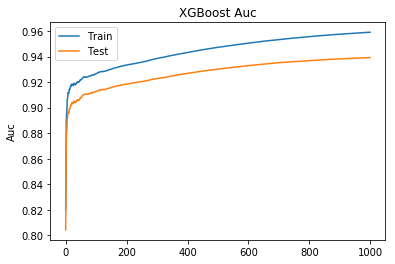

In [107]:
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Auc')
plt.title('XGBoost Auc')
plt.show()


In [108]:
param_grid= {'max_depth': [8,9,10,11,12,13,14,15,16,17]}
from sklearn.model_selection import GridSearchCV
grid=GridSearchCV(XGBClassifier(n_estimators=24), param_grid, scoring="f1",n_jobs=-1)
%time grid.fit(np.array(sent_vectors_train),y_train)


CPU times: user 41.7 s, sys: 696 ms, total: 42.4 s
Wall time: 8min 3s


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=24,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

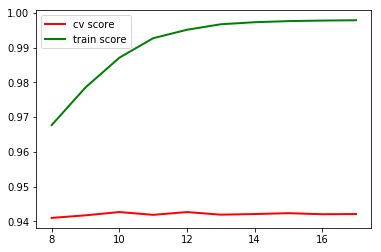

In [109]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["max_depth"],cv_scores, param_grid["max_depth"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.legend()
plt.show()

In [110]:
from sklearn.model_selection import RandomizedSearchCV
params = {
        'gamma': [0, 1, 5],
        'learning_rate': [0.01,0.05,0.1],
        'subsample':[0.8,0.9,1]
        }
random_search = RandomizedSearchCV(XGBClassifier(n_estimators=24,max_depth=9), param_distributions=params, n_iter=10, scoring='f1')
%time random_search.fit(np.array(sent_vectors_train),y_train)

CPU times: user 11min 56s, sys: 2.97 s, total: 11min 59s
Wall time: 11min 59s


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=24,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.8, 0.9, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

Accuracy for learning rate: 0.1 ,n_estimators: 1
89.54084539136379
[[ 2458  2103]
 [  651 21119]]


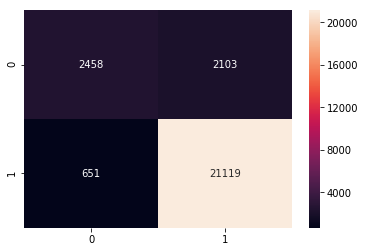

In [111]:
from sklearn.metrics import accuracy_score
optimal_param=random_search.best_params_ 
pre=random_search.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for learning rate:",optimal_param['learning_rate'],',gamma:',optimal_param['gamma'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

Accuracy for learning rate: 0.1 ,n_estimators: 1
94.85368314833501
[[ 6994  2626]
 [  536 51286]]


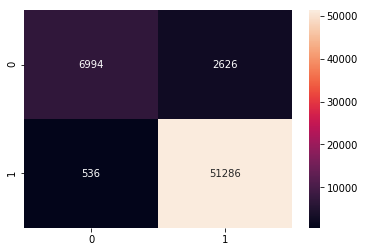

In [112]:
from sklearn.metrics import accuracy_score
optimal_param=random_search.best_params_ 
pre=random_search.predict(sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for learning rate:",optimal_param['learning_rate'],',n_estimators:',optimal_param['gamma'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

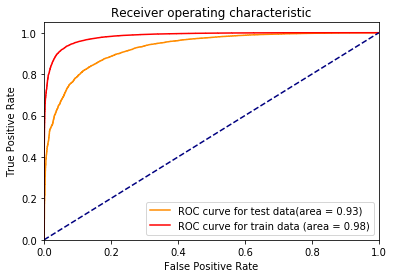

In [113]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(random_search.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [114]:
# Please write all the code with proper documentation
from xgboost import XGBClassifier
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
eval_set = [(np.array(tfidf_sent_vectors_train), y_train), (np.array(tfidf_sent_vectors_test), y_test)]
eval_metric = ["auc"]
%time model.fit(np.array(tfidf_sent_vectors_train), y_train, eval_metric=eval_metric, eval_set=eval_set,early_stopping_rounds=10, verbose=True)



[0]	validation_0-auc:0.767141	validation_1-auc:0.749305
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80992	validation_1-auc:0.795914
[2]	validation_0-auc:0.834393	validation_1-auc:0.822125
[3]	validation_0-auc:0.850708	validation_1-auc:0.836619
[4]	validation_0-auc:0.852543	validation_1-auc:0.836362
[5]	validation_0-auc:0.860278	validation_1-auc:0.844423
[6]	validation_0-auc:0.86157	validation_1-auc:0.846381
[7]	validation_0-auc:0.862816	validation_1-auc:0.848038
[8]	validation_0-auc:0.866267	validation_1-auc:0.851101
[9]	validation_0-auc:0.864467	validation_1-auc:0.848244
[10]	validation_0-auc:0.863387	validation_1-auc:0.846142
[11]	validation_0-auc:0.865998	validation_1-auc:0.84834
[12]	validation_0-auc:0.867748	validation_1-auc:0.850168
[13]	validation_0-auc:0.867481	validation_1-auc:0.850775
[14]	validation_0-auc:0.868333	validation_1-auc:0.8515
[15

[142]	validation_0-auc:0.888599	validation_1-auc:0.872514
[143]	validation_0-auc:0.888553	validation_1-auc:0.872482
[144]	validation_0-auc:0.888691	validation_1-auc:0.872578
[145]	validation_0-auc:0.88878	validation_1-auc:0.872626
[146]	validation_0-auc:0.889053	validation_1-auc:0.872849
[147]	validation_0-auc:0.889113	validation_1-auc:0.8729
[148]	validation_0-auc:0.889286	validation_1-auc:0.873042
[149]	validation_0-auc:0.889465	validation_1-auc:0.873242
[150]	validation_0-auc:0.889476	validation_1-auc:0.873294
[151]	validation_0-auc:0.889384	validation_1-auc:0.87314
[152]	validation_0-auc:0.889593	validation_1-auc:0.873343
[153]	validation_0-auc:0.889821	validation_1-auc:0.873554
[154]	validation_0-auc:0.889922	validation_1-auc:0.873693
[155]	validation_0-auc:0.889837	validation_1-auc:0.873544
[156]	validation_0-auc:0.890028	validation_1-auc:0.873715
[157]	validation_0-auc:0.890178	validation_1-auc:0.873827
[158]	validation_0-auc:0.890364	validation_1-auc:0.87403
[159]	validation_0-

[284]	validation_0-auc:0.900941	validation_1-auc:0.883796
[285]	validation_0-auc:0.901088	validation_1-auc:0.883918
[286]	validation_0-auc:0.901185	validation_1-auc:0.883989
[287]	validation_0-auc:0.901285	validation_1-auc:0.88408
[288]	validation_0-auc:0.901394	validation_1-auc:0.884151
[289]	validation_0-auc:0.901499	validation_1-auc:0.884207
[290]	validation_0-auc:0.901526	validation_1-auc:0.884247
[291]	validation_0-auc:0.901554	validation_1-auc:0.884241
[292]	validation_0-auc:0.901615	validation_1-auc:0.884267
[293]	validation_0-auc:0.901729	validation_1-auc:0.884375
[294]	validation_0-auc:0.901826	validation_1-auc:0.884477
[295]	validation_0-auc:0.901955	validation_1-auc:0.884581
[296]	validation_0-auc:0.902025	validation_1-auc:0.884645
[297]	validation_0-auc:0.902097	validation_1-auc:0.884677
[298]	validation_0-auc:0.902181	validation_1-auc:0.884781
[299]	validation_0-auc:0.902287	validation_1-auc:0.884905
[300]	validation_0-auc:0.902379	validation_1-auc:0.884982
[301]	validatio

[426]	validation_0-auc:0.91205	validation_1-auc:0.893506
[427]	validation_0-auc:0.912107	validation_1-auc:0.893552
[428]	validation_0-auc:0.912146	validation_1-auc:0.893556
[429]	validation_0-auc:0.912225	validation_1-auc:0.893623
[430]	validation_0-auc:0.91231	validation_1-auc:0.893665
[431]	validation_0-auc:0.912414	validation_1-auc:0.893797
[432]	validation_0-auc:0.912474	validation_1-auc:0.893887
[433]	validation_0-auc:0.912562	validation_1-auc:0.893968
[434]	validation_0-auc:0.91264	validation_1-auc:0.894043
[435]	validation_0-auc:0.912682	validation_1-auc:0.894061
[436]	validation_0-auc:0.912726	validation_1-auc:0.894105
[437]	validation_0-auc:0.912784	validation_1-auc:0.894153
[438]	validation_0-auc:0.912855	validation_1-auc:0.894213
[439]	validation_0-auc:0.912916	validation_1-auc:0.894275
[440]	validation_0-auc:0.912998	validation_1-auc:0.894365
[441]	validation_0-auc:0.913062	validation_1-auc:0.89446
[442]	validation_0-auc:0.913096	validation_1-auc:0.894474
[443]	validation_0

[568]	validation_0-auc:0.920141	validation_1-auc:0.900527
[569]	validation_0-auc:0.920175	validation_1-auc:0.900566
[570]	validation_0-auc:0.920208	validation_1-auc:0.900595
[571]	validation_0-auc:0.920266	validation_1-auc:0.900631
[572]	validation_0-auc:0.92031	validation_1-auc:0.900666
[573]	validation_0-auc:0.920364	validation_1-auc:0.900715
[574]	validation_0-auc:0.920403	validation_1-auc:0.900731
[575]	validation_0-auc:0.920454	validation_1-auc:0.900762
[576]	validation_0-auc:0.920516	validation_1-auc:0.900812
[577]	validation_0-auc:0.920584	validation_1-auc:0.900864
[578]	validation_0-auc:0.920631	validation_1-auc:0.9009
[579]	validation_0-auc:0.920686	validation_1-auc:0.900975
[580]	validation_0-auc:0.920747	validation_1-auc:0.901022
[581]	validation_0-auc:0.920802	validation_1-auc:0.901075
[582]	validation_0-auc:0.920856	validation_1-auc:0.901116
[583]	validation_0-auc:0.920881	validation_1-auc:0.901117
[584]	validation_0-auc:0.920928	validation_1-auc:0.901164
[585]	validation_

[710]	validation_0-auc:0.92604	validation_1-auc:0.905382
[711]	validation_0-auc:0.926074	validation_1-auc:0.905423
[712]	validation_0-auc:0.926113	validation_1-auc:0.905448
[713]	validation_0-auc:0.926158	validation_1-auc:0.9055
[714]	validation_0-auc:0.926186	validation_1-auc:0.905512
[715]	validation_0-auc:0.926219	validation_1-auc:0.905553
[716]	validation_0-auc:0.926251	validation_1-auc:0.905584
[717]	validation_0-auc:0.926282	validation_1-auc:0.905598
[718]	validation_0-auc:0.926321	validation_1-auc:0.905638
[719]	validation_0-auc:0.926348	validation_1-auc:0.905662
[720]	validation_0-auc:0.92638	validation_1-auc:0.905686
[721]	validation_0-auc:0.926431	validation_1-auc:0.905743
[722]	validation_0-auc:0.926475	validation_1-auc:0.905773
[723]	validation_0-auc:0.926492	validation_1-auc:0.905788
[724]	validation_0-auc:0.926528	validation_1-auc:0.905815
[725]	validation_0-auc:0.926545	validation_1-auc:0.90583
[726]	validation_0-auc:0.92658	validation_1-auc:0.905863
[727]	validation_0-a

[852]	validation_0-auc:0.930528	validation_1-auc:0.909009
[853]	validation_0-auc:0.930548	validation_1-auc:0.909025
[854]	validation_0-auc:0.930562	validation_1-auc:0.909038
[855]	validation_0-auc:0.930581	validation_1-auc:0.909069
[856]	validation_0-auc:0.930607	validation_1-auc:0.909112
[857]	validation_0-auc:0.930622	validation_1-auc:0.909121
[858]	validation_0-auc:0.930648	validation_1-auc:0.90915
[859]	validation_0-auc:0.930672	validation_1-auc:0.909157
[860]	validation_0-auc:0.9307	validation_1-auc:0.909158
[861]	validation_0-auc:0.930736	validation_1-auc:0.909172
[862]	validation_0-auc:0.930754	validation_1-auc:0.909172
[863]	validation_0-auc:0.930773	validation_1-auc:0.909187
[864]	validation_0-auc:0.930785	validation_1-auc:0.909201
[865]	validation_0-auc:0.930811	validation_1-auc:0.90922
[866]	validation_0-auc:0.930834	validation_1-auc:0.909241
[867]	validation_0-auc:0.930855	validation_1-auc:0.90926
[868]	validation_0-auc:0.930887	validation_1-auc:0.909296
[869]	validation_0-

[994]	validation_0-auc:0.933984	validation_1-auc:0.911558
[995]	validation_0-auc:0.934017	validation_1-auc:0.911588
[996]	validation_0-auc:0.934032	validation_1-auc:0.911604
[997]	validation_0-auc:0.934057	validation_1-auc:0.911612
[998]	validation_0-auc:0.934082	validation_1-auc:0.911631
[999]	validation_0-auc:0.934106	validation_1-auc:0.911642
CPU times: user 6min 24s, sys: 964 ms, total: 6min 25s
Wall time: 6min 24s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

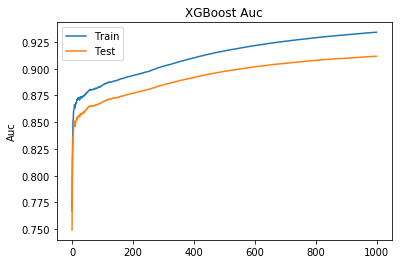

In [115]:
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Auc')
plt.title('XGBoost Auc')
plt.show()


In [118]:
param_grid= {'max_depth': [6,7,8,9,10]}
from sklearn.model_selection import GridSearchCV
grid=GridSearchCV(XGBClassifier(n_estimators=100), param_grid, scoring="f1",n_jobs=-1)
%time grid.fit(np.array(tfidf_sent_vectors_train),y_train)


CPU times: user 2min 37s, sys: 848 ms, total: 2min 38s
Wall time: 12min 29s


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [6, 7, 8, 9, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1', verbose=0)

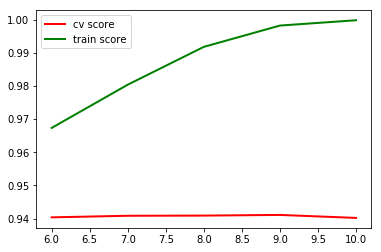

In [119]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
lines = plt.plot(param_grid["max_depth"],cv_scores, param_grid["max_depth"],train_scores )
plt.setp(lines[0], color='r', linewidth=2.0, label="cv score")
plt.setp(lines[1], color='g', linewidth=2.0,label="train score")
plt.legend()
plt.show()

In [120]:
from sklearn.model_selection import RandomizedSearchCV
params = {
        'gamma': [0, 1, 5],
        'learning_rate': [0.05,0.1],
        'subsample':[0.8,0.9,1]
        }
random_search = RandomizedSearchCV(XGBClassifier(n_estimators=100,max_depth=9), param_distributions=params, n_iter=10, scoring='f1')
%time random_search.fit(np.array(tfidf_sent_vectors_train),y_train)

CPU times: user 50min, sys: 4.22 s, total: 50min 4s
Wall time: 50min 5s


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': [0, 1, 5], 'learning_rate': [0.05, 0.1], 'subsample': [0.8, 0.9, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

Accuracy for learning rate: 0.1 ,gamma: 0
88.78888002734419
[[ 2471  2090]
 [  862 20908]]


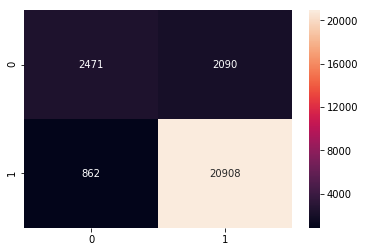

In [122]:
from sklearn.metrics import accuracy_score
optimal_param=random_search.best_params_ 
pre=random_search.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for learning rate:",optimal_param['learning_rate'],',gamma:',optimal_param['gamma'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

Accuracy for learning rate: 0.1 ,gama: 0
91.23726441196575
[[ 5795  3825]
 [ 1559 50263]]


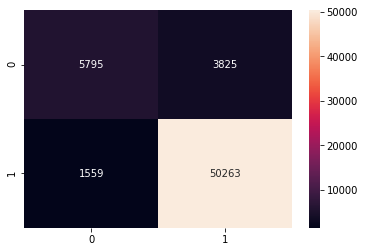

In [124]:
from sklearn.metrics import accuracy_score
optimal_param=random_search.best_params_ 
pre=random_search.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for learning rate:",optimal_param['learning_rate'],',gama:',optimal_param['gamma'])
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt='g')
print(conf_matr)

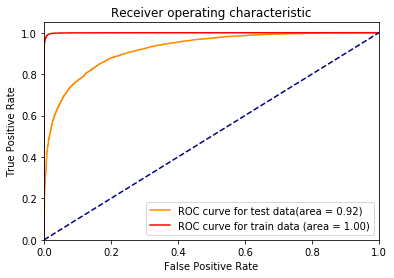

In [125]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(random_search.best_estimator_, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# [6] Conclusions

In [7]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
table= PrettyTable()
table.field_names = ["Vectorizer","Model","Max Depth","Estimators","Accuracy","AUC"]
table.add_row(["Bow","Random Forest",29,112,86.130,0.91])
table.add_row(["Tfidf","Random Forest",38,103,87.47,0.92])
table.add_row(["Avg-W2v","Random Forest",12,98,88.659,0.93])
table.add_row(["Tfidf-W2v","Random Forest",12,126,87.2621,0.90])
table.add_row(["Bow","XGBoost",14,67,89.529,0.93])
table.add_row(["Tfidf","XGBoost",10,13,87.053,0.88])
table.add_row(["Avg-W2v","XGBoost",9,24,89.540,0.93])
table.add_row(["Tfidf-W2v","XGBoost",9,100,88.788,0.92])

In [8]:
print(table)

+------------+---------------+-----------+------------+----------+------+
| Vectorizer |     Model     | Max Depth | Estimators | Accuracy | AUC  |
+------------+---------------+-----------+------------+----------+------+
|    Bow     | Random Forest |     29    |    112     |  86.13   | 0.91 |
|   Tfidf    | Random Forest |     38    |    103     |  87.47   | 0.92 |
|  Avg-W2v   | Random Forest |     12    |     98     |  88.659  | 0.93 |
| Tfidf-W2v  | Random Forest |     12    |    126     | 87.2621  | 0.9  |
|    Bow     |    XGBoost    |     14    |     67     |  89.529  | 0.93 |
|   Tfidf    |    XGBoost    |     10    |     13     |  87.053  | 0.88 |
|  Avg-W2v   |    XGBoost    |     9     |     24     |  89.54   | 0.93 |
| Tfidf-W2v  |    XGBoost    |     9     |    100     |  88.788  | 0.92 |
+------------+---------------+-----------+------------+----------+------+


From the above table, it can be seen that,Xgboost Model with Avg-W2v gave the highest AUC score, accuracy of  for max_depth =9,n_estimators=24.